# Aim 3: find out the characteristics of more susceptible group

1. divide patients into two groups: who is hyperchloremic between 24 and 48h
2. look at the variables from the first 24h 
3. univariate analysis

In [22]:
import numpy as np
import pandas as pd
import datetime
import statsmodels.api as sm

from IPython.display import display
from scipy.stats import chi2_contingency, kruskal
from tableone import TableOne

pd.options.display.precision = 3

## Load useful DataFrames

In [37]:
# Target Group: adult patients' first icu visit
df = pd.read_csv('icu_first_18.csv')
df = df.drop(df.columns[0], axis=1)

# Create ICU Id list
icu = []
for icuid in df['icustay_id']:
    icu.append(icuid)

# Max chloride
df = pd.read_csv('chloride.csv')
df = df[df['icustay_id'].isin(icu)]
df = df.set_index(['subject_id','hadm_id'])
df = df.filter(['icustay_id','icu_day','chloride_max'])
df = df.dropna(subset = ['chloride_max'])

# Chloride >= 110 in the second day
df_chl = df.query('icu_day == 2')
df_chl['chl_110'] = (df_chl['chloride_max'] >= 110).astype(int)

# Demographic
df = pd.read_csv('adm_demographics.csv')
df = df.set_index(['subject_id', 'hadm_id'])
df_demo = df.filter(['insurance','ethnicity','age','gender'])

# Weight
df = pd.read_csv('weight.csv')
df = df[df['icustay_id'].isin(icu)]
df_wt = df.filter(['icustay_id','day','weight'])

# GCS(Glasgow coma scale)
df = pd.read_csv('gcs_pan.csv')
df = df[df['icustay_id'].isin(icu)]
df_gcs = df.filter(['icustay_id','day','mingcs'])

# First-day Vitals(Merge with GCS and Weight)
df = pd.read_csv('vitals_pan.csv')
df = df[df['icustay_id'].isin(icu)]
df = df.set_index(['subject_id','hadm_id','icustay_id'])
df_vitals = df.filter(['day', 'heartrate_max','sysbp_min','diasbp_min','resprate_max','spo2_min','tempc_max'])
df_vitals = df_vitals.reset_index()
df_vitals = df_vitals.merge(df_wt, on = ['icustay_id','day']).merge(df_gcs, on = ['icustay_id','day'])
df_vitals = df_vitals.query('day == 1')

# Medication from prescription table
df = pd.read_csv('medication.csv')
df_med = df.drop(df.columns[[0,3]], axis=1)
df = pd.read_csv('icu_first_18.csv')
df = df.drop(df.columns[0], axis=1)
df = df_med.merge(df, on = ['subject_id','hadm_id'])
df['taken'] = ((pd.to_datetime(df['intime']) <= pd.to_datetime(df['startdate'])) & 
               ((pd.to_datetime(df['startdate']) <= (pd.to_datetime(df['intime']) + datetime.timedelta(days=1)))))
df = df.filter(['subject_id','hadm_id','icustay_id','drug','taken'])
df_med = df.set_index(['subject_id','hadm_id','icustay_id'])
df_med = df_med.groupby(['subject_id','hadm_id','icustay_id','drug']).any()
df_med = df_med['taken'].unstack()
df_med = (df_med * 1).fillna(0)

# Intake and output
df = pd.read_csv('fluid_io.csv')
df = df[df['icustay_id'].isin(icu)]
df = df.query('icu_day == 1')
df_fluid = df.set_index(['subject_id','hadm_id','icustay_id'])
df_fluid.head()

# Diagnosis Code(group by elixhauser)
df = pd.read_csv('elixhauser.csv')
df_icd = df.drop(df.columns[[0]], axis=1)

# Labs
df = pd.read_csv('labs1.csv')
df = df.drop(df.columns[0], axis=1)
df = df[df['icustay_id'].isin(icu)]
df_labs = df.query('day == 1')

/Users/panyiheng/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Summary statistics

## _Table 1(a). Demographics_

In [25]:
df_chl = df_chl.reset_index()
df_chl = df_chl.set_index(['subject_id','hadm_id'])
df_combined = df_demo.join(df_chl, how='inner')
columns = ['age', 'gender', 'ethnicity']
categorical = ['gender', 'ethnicity']
groupby = 'chl_110'
display(TableOne(df_combined, columns, categorical, groupby,
                 labels={'age': 'Age', 'gender': 'Gender', 'ethnicity': 'Ethnicity',
                         'chl_110': 'Hyperchloremia (>=110)'},
                 pval=True, isnull=False, label_suffix=True))

Grouped by Hyperchloremia (>=110)                                        
                                                          0            1    pval              ptest
variable         level                                                                             
n                                                     24452         7293                           
Age, mean (SD)                                  64.4 (16.7)  66.0 (17.7)  <0.001  Two Sample T-test
Gender, n (%)    F                             10415 (42.6)  3646 (50.0)  <0.001        Chi-squared
                 M                             14037 (57.4)  3647 (50.0)                           
Ethnicity, n (%) ASIAN                            496 (2.0)    226 (3.1)  <0.001        Chi-squared
                 BLACK                           2254 (9.2)   733 (10.1)                           
                 HISPANIC                         767 (3.1)    240 (3.3)                           
                 OTHER                          3314 (13.6)  1020 (14.0)                           
                 WHITE                         17621 (72.1)  5074 (69.6)                           
[1] Warning, Hartigan's Dip Test reports possible multimodal distributions for: age.
[2] Warning, test for normality reports non-normal distributions for: age.

chl_110
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: age, dtype: object

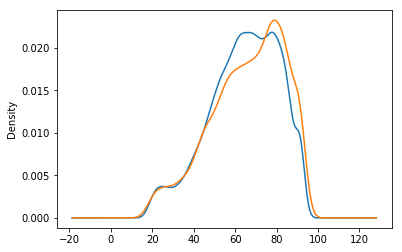

In [26]:
df_combined.groupby('chl_110').age.plot(kind='kde')

In [27]:
df_combined.describe()

,age,icustay_id,icu_day,chloride_max,chl_110
count,31745.000,31745.000,31745.0,31745.000,31745.000
mean,64.763,250047.148,2.0,105.650,0.230
std,16.971,28849.336,0.0,5.876,0.421
min,18.008,200001.000,2.0,70.000,0.000
25%,53.674,225049.000,2.0,102.000,0.000
50%,66.493,250232.000,2.0,106.000,0.000
75%,78.241,274966.000,2.0,109.000,0.000
max,91.400,299998.000,2.0,145.000,1.000


## _Table 1(b). Vitals_

In [28]:
df_chl = df_chl.reset_index()
df_chl = df_chl.set_index(['subject_id','hadm_id','icustay_id'])
df_vitals = df_vitals.reset_index()
df_vitals = df_vitals.set_index(['subject_id','hadm_id','icustay_id'])
df_combined = df_vitals.join(df_chl, how='inner')

columns = ['heartrate_max','sysbp_min','diasbp_min','resprate_max','spo2_min','tempc_max','weight','mingcs']
groupby = 'chl_110'
display(TableOne(df_combined, columns,categorical = [], groupby = 'chl_110',
                 labels={
                         'chl_110': 'Hyperchloremia (>=110)'},
                 pval=True, isnull=False, label_suffix=True))

Grouped by Hyperchloremia (>=110)                                         
                                                               0             1    pval              ptest
variable                 level                                                                           
n                                                           8146          2126                           
heartrate_max, mean (SD)                            103.2 (19.7)  107.2 (22.1)  <0.001  Two Sample T-test
sysbp_min, mean (SD)                                 92.0 (17.4)   88.6 (17.9)  <0.001  Two Sample T-test
diasbp_min, mean (SD)                                43.8 (11.7)   41.7 (11.6)  <0.001  Two Sample T-test
resprate_max, mean (SD)                               27.4 (6.4)    27.8 (6.5)   0.007  Two Sample T-test
spo2_min, mean (SD)                                   91.5 (7.7)    91.7 (8.6)   0.288  Two Sample T-test
tempc_max, mean (SD)                                  37.5 (0.8)    37.6 (0.8)   0.044  Two Sample T-test
weight, mean (SD)                                    82.4 (24.4)   75.3 (20.3)  <0.001  Two Sample T-test
mingcs, mean (SD)                                     12.8 (3.4)    11.7 (3.8)  <0.001  Two Sample T-test
[1] Warning, Hartigan's Dip Test reports possible multimodal distributions for: diasbp_min, heartrate_max, mingcs, resprate_max, spo2_min, sysbp_min, tempc_max, weight.
[2] Warning, Tukey test indicates far outliers in: diasbp_min, heartrate_max, mingcs, resprate_max, spo2_min, sysbp_min, tempc_max, weight.
[3] Warning, test for normality reports non-normal distributions for: diasbp_min, heartrate_max, mingcs, resprate_max, spo2_min, sysbp_min, tempc_max, weight.

chl_110
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: weight, dtype: object

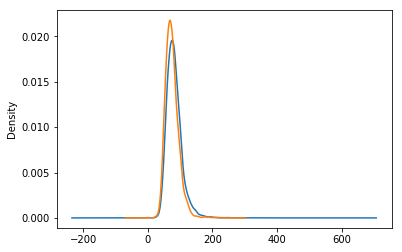

In [29]:
df_combined.groupby('chl_110').weight.plot(kind='kde')

In [31]:
df_combined.describe().T.to_csv('vitals_summary.csv')

## _Table 1(c). Medication_ 

In [10]:
df_chl = df_chl.reset_index()
df_chl = df_chl.set_index(['subject_id','hadm_id','icustay_id'])
df_combined = df_med.join(df_chl, how='inner')
columns = ['dopamine','epinephrine','norepinephrine','vasopressin']
categorical = ['dopamine','epinephrine','norepinephrine','vasopressin']
groupby = 'chl_110'
display(TableOne(df_combined, columns,categorical, groupby = 'chl_110',
                                  labels={
                         'chl_110': 'Hyperchloremia (>=110)'},
                 pval=True, isnull=False, label_suffix=True))

Grouped by Hyperchloremia (>=110)                                  
                                                            0            1    pval        ptest
variable              level                                                                    
n                                                        5439         2340                     
dopamine, n (%)       0                           4976 (91.5)  2166 (92.6)   0.123  Chi-squared
                      1                             463 (8.5)    174 (7.4)                     
epinephrine, n (%)    0                           5191 (95.4)  2249 (96.1)   0.205  Chi-squared
                      1                             248 (4.6)     91 (3.9)                     
norepinephrine, n (%) 0                           4155 (76.4)  1646 (70.3)  <0.001  Chi-squared
                      1                           1284 (23.6)   694 (29.7)                     
vasopressin, n (%)    0                           4997 (91.9)  2133 (91.2)   0.313  Chi-squared
                      1                             442 (8.1)    207 (8.8)

## _Table 1(d). FLuid balance_

In [11]:
df_chl = df_chl.reset_index()
df_chl = df_chl.set_index(['subject_id','hadm_id','icustay_id'])
df_chl = df_chl.drop(df_chl.columns[[0]], axis = 1)
df_combined = df_fluid.join(df_chl, how='inner')

In [12]:
columns = ['fluid_net_input_ml']
groupby = 'chl_110'
display(TableOne(df_combined, columns,categorical = [], groupby = 'chl_110',
                 labels={
                         'chl_110': 'Hyperchloremia (>=110)'},
                 pval=True, isnull=False, label_suffix=True))

Grouped by Hyperchloremia (>=110)                                            
                                                                    0                1    pval              ptest
variable                      level                                                                              
n                                                               19464             4797                           
fluid_net_input_ml, mean (SD)                         1051.8 (1955.6)  1646.4 (1900.0)  <0.001  Two Sample T-test
[1] Warning, test for normality reports non-normal distributions for: fluid_net_input_ml.

chl_110
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: fluid_net_input_ml, dtype: object

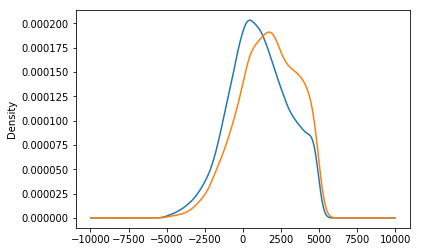

In [13]:
df_combined.groupby('chl_110').fluid_net_input_ml.plot(kind='kde')

In [14]:
df_combined.describe()

,icu_day,fluid_input_ml,fluid_output_ml,fluid_net_input_ml,chloride_max,chl_110
count,24261.0,24261.000,24261.000,24261.000,24261.000,24261.000
mean,1.0,3775.071,2605.673,1169.398,105.101,0.198
std,0.0,2479.514,1924.292,1959.093,5.802,0.398
min,1.0,0.000,0.000,-4985.890,74.000,0.000
25%,1.0,1930.500,1350.000,-180.862,102.000,0.000
50%,1.0,3314.410,2243.000,1116.530,105.000,0.000
75%,1.0,5197.073,3463.000,2607.640,109.000,0.000
max,1.0,58280.187,56414.000,4999.470,145.000,1.000


## _Table 1(e). Diagnosis_

In [15]:
df_chl = df_chl.reset_index()
df_combined = df_chl.merge(df_icd, on = 'hadm_id')

In [16]:
columns = ['congestive_heart_failure',
       'cardiac_arrhythmias', 'valvular_disease', 'pulmonary_circulation',
       'peripheral_vascular', 'hypertension', 'paralysis',
       'other_neurological', 'chronic_pulmonary', 'diabetes_uncomplicated',
       'diabetes_complicated', 'hypothyroidism', 'renal_failure',
       'liver_disease', 'peptic_ulcer', 'aids', 'lymphoma',
       'metastatic_cancer', 'solid_tumor', 'rheumatoid_arthritis',
       'coagulopathy', 'obesity', 'weight_loss', 'fluid_electrolyte',
       'blood_loss_anemia', 'deficiency_anemias', 'alcohol_abuse',
       'drug_abuse', 'psychoses', 'depression']

categorical = ['congestive_heart_failure',
       'cardiac_arrhythmias', 'valvular_disease', 'pulmonary_circulation',
       'peripheral_vascular', 'hypertension', 'paralysis',
       'other_neurological', 'chronic_pulmonary', 'diabetes_uncomplicated',
       'diabetes_complicated', 'hypothyroidism', 'renal_failure',
       'liver_disease', 'peptic_ulcer', 'aids', 'lymphoma',
       'metastatic_cancer', 'solid_tumor', 'rheumatoid_arthritis',
       'coagulopathy', 'obesity', 'weight_loss', 'fluid_electrolyte',
       'blood_loss_anemia', 'deficiency_anemias', 'alcohol_abuse',
       'drug_abuse', 'psychoses', 'depression']
groupby = 'chl_110'
display(TableOne(df_combined, columns,categorical, groupby = 'chl_110',
                                  labels={
                         'chl_110': 'Hyperchloremia (>=110)'},
                 pval=True, isnull=False, label_suffix=True))

Grouped by Hyperchloremia (>=110)                                  
                                                                      0            1    pval        ptest
variable                        level                                                                    
n                                                                 24452         7293                     
congestive_heart_failure, n (%) 0.0                        16312 (66.8)  5303 (72.9)  <0.001  Chi-squared
                                1.0                         8092 (33.2)  1970 (27.1)                     
cardiac_arrhythmias, n (%)      0.0                        14672 (60.1)  4680 (64.3)  <0.001  Chi-squared
                                1.0                         9732 (39.9)  2593 (35.7)                     
valvular_disease, n (%)         0.0                        20989 (86.0)  6559 (90.2)  <0.001  Chi-squared
                                1.0                         3415 (14.0)    714 (9.8)                     
pulmonary_circulation, n (%)    0.0                        22381 (91.7)  6874 (94.5)  <0.001  Chi-squared
                                1.0                          2023 (8.3)    399 (5.5)                     
peripheral_vascular, n (%)      0.0                        22157 (90.8)  6706 (92.2)  <0.001  Chi-squared
                                1.0                          2247 (9.2)    567 (7.8)                     
hypertension, n (%)             0                          10940 (44.7)  3475 (47.6)  <0.001  Chi-squared
                                1                          13512 (55.3)  3818 (52.4)                     
paralysis, n (%)                0.0                        23731 (97.2)  6983 (96.0)  <0.001  Chi-squared
                                1.0                           673 (2.8)    290 (4.0)                     
other_neurological, n (%)       0.0                        21721 (89.0)  6100 (83.9)  <0.001  Chi-squared
                                1.0                         2683 (11.0)  1173 (16.1)                     
chronic_pulmonary, n (%)        0.0                        18360 (75.2)  5927 (81.5)  <0.001  Chi-squared
                                1.0                         6044 (24.8)  1346 (18.5)                     
diabetes_uncomplicated, n (%)   0                          19377 (79.2)  5896 (80.8)   0.003  Chi-squared
                                1                           5075 (20.8)  1397 (19.2)                     
diabetes_complicated, n (%)     0.0                        22505 (92.2)  6802 (93.5)  <0.001  Chi-squared
                                1.0                          1899 (7.8)    471 (6.5)                     
hypothyroidism, n (%)           0.0                        21771 (89.2)  6487 (89.2)   0.983  Chi-squared
                                1.0                         2633 (10.8)   786 (10.8)                     
renal_failure, n (%)            0.0                        20105 (82.4)  6096 (83.8)   0.005  Chi-squared
                                1.0                         4299 (17.6)  1177 (16.2)                     
liver_disease, n (%)            0.0                        21763 (89.2)  6325 (87.0)  <0.001  Chi-squared
                                1.0                         2641 (10.8)   948 (13.0)                     
peptic_ulcer, n (%)             0.0                        24193 (99.1)  7193 (98.9)   0.076  Chi-squared
                                1.0                           211 (0.9)     80 (1.1)                     
aids, n (%)                     0.0                        24251 (99.4)  7215 (99.2)   0.137  Chi-squared
                                1.0                           153 (0.6)     58 (0.8)                     
lymphoma, n (%)                 0.0                        24031 (98.5)  7170 (98.6)   0.525  Chi-squared
                                1.0                           373 (1.5)    103 (1.4)                     
metastatic

## _Table 1(e). Labs_

In [38]:
df_labs.describe().T.to_csv('labs_summary.csv')

## Define useful functions

In [17]:
def run_kruskal(df_neg, df_pos):
    """Display results of a Kruskal-Wallis H test.
    
    @param df_neg: DataFrame containing the negative samples
    @param df_pos: DataFrame containing the positive samples
    """
    summary = pd.concat([df_neg.describe(), df_pos.describe()], axis=1)
    summary.columns = ['(-)', '(+)']
    display(summary)
    print (kruskal(df_neg, df_pos))

# Univariate association for non-normal distribution

## 1. age

In [18]:
df_chl = df_chl.reset_index()
df_chl = df_chl.set_index(['subject_id','hadm_id'])
df_combined = df_demo.join(df_chl, how='inner')

In [19]:
run_kruskal(df_combined.query('chl_110 == 0').filter(['age']),
            df_combined.query('chl_110 == 1').filter(['age']))

,(-),(+)
count,24452.000,7293.000
mean,64.383,66.036
std,16.744,17.652
min,18.008,18.033
25%,53.528,54.337
50%,65.970,68.447
75%,77.647,80.195
max,91.400,91.400


KruskalResult(statistic=74.90376458296488, pvalue=4.942267490848014e-18)


## 2.